Files:

data.txt contains the data for the task

instructions.md is a markdown file (can open via notepad or Jupyter notebook) with the instructions

 

The instructions are as follows:

 

You are given a dataset to predict cognitive test scores of preschoolers given characteristics of their mothers.

 

Data dictionary:

1. i - mother's IQ
2. a - mother's age at child's birth
3. h - indicator showing whether mother completed high school (1=True, 0=False)
4. w = 1: mother did not work in first three years of child’s life
5. w = 2: mother worked in second or third year of child’s life
6. w = 3: mother worked part-time in first year of child’s life
7. w = 4: mother worked full-time in first year of child’s life
8. score - child's IQ (regressand)
 

Tasks:

1. Prepare the data, rename variables as you see fit and justify. Propose the types of data for each variable (python data types).

2. Transform the data so it's easy to analyze - describe what you did and why

3. Perform the exploratory data analysis

4. Perform a linear regression where the regressand is child's IQ

    A. using a single predictor

    B. using multiple predictors

    C. using multiple predictors with an interaction term

   

    For each case, explain your model, model assumptions and how to interpret the regression coefficients.

   

For each task please provide suitable markdown comments and visualizations supporting your work including model diagnostics and evaluation.

## <font color='blue'><u> Importing data file </u></font>

In [713]:
import csv
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from textwrap import wrap
import scipy
from scipy import stats
from scipy.stats import shapiro 
from scipy.stats import ttest_ind, mannwhitneyu, kruskal
import statsmodels.api as sm
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
warnings.filterwarnings("ignore")
try:
    data = pd.read_csv('data.txt', delimiter='|')
    print('Data successfully loaded')
except Exception as e:
    print(e)

'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte


## <font color='blue'><u> Data Preparation</u></font>

## As there is this error this means the txt file might have non-UTF-8 characters

In [714]:
!grep -axv '.*' data.txt

### There are 2 rows in the text file which has non-UTF-8 characters.  By looking at the data, we can see that the first row is just the header of the file while the second row might or might not have any data. As these characters do not make sense, it makes sense to remove the rows. We can remove these rows and then check through the Serial number datapoint in the text file if some data was deleted.

In [715]:
data = pd.read_csv('data.txt', delimiter='|',encoding='utf-8', encoding_errors='ignore')

In [716]:
data

,Unnamed: 0,variable,value
0,0,score,65
1,1,score,98
2,2,score,85
3,3,score,83
4,4,score,115
...,...,...,...
2166,2165,a,21
2167,2166,a,23
2168,2167,a,24
2169,2168,a,21


In [717]:
data = data.rename(columns={'Unnamed: 0':'serial_number'})

### Finding row which had non-UTF-8 characters & removing it

In [718]:
for ind in data.index:
    if data['serial_number'][ind] != str(ind):
        print(ind)
        break

894


In [719]:
data[data.index == 894]

,serial_number,variable,value
894,0xC0,င,မ


In [720]:
data = data.drop(index=894)

In [721]:
data

,serial_number,variable,value
0,0,score,65
1,1,score,98
2,2,score,85
3,3,score,83
4,4,score,115
...,...,...,...
2166,2165,a,21
2167,2166,a,23
2168,2167,a,24
2169,2168,a,21


In [722]:
data = data.reset_index()
data = data.drop(['index'],axis = 1)

In [723]:
data

,serial_number,variable,value
0,0,score,65
1,1,score,98
2,2,score,85
3,3,score,83
4,4,score,115
...,...,...,...
2165,2165,a,21
2166,2166,a,23
2167,2167,a,24
2168,2168,a,21


### The serial_number column should now have integer values so converting its datatype

In [724]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2170 entries, 0 to 2169
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   serial_number  2170 non-null   object
 1   variable       2170 non-null   object
 2   value          2170 non-null   object
dtypes: object(3)
memory usage: 51.0+ KB


In [725]:
data = data.astype({'serial_number':int})

In [726]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2170 entries, 0 to 2169
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   serial_number  2170 non-null   int64 
 1   variable       2170 non-null   object
 2   value          2170 non-null   object
dtypes: int64(1), object(2)
memory usage: 51.0+ KB


### Checking if there is any number missing in serial_number 

In [727]:
list_of_serial_numbers_that_should_exist = list(range(0,len(data)))

In [728]:
counter = 0
for i in range(len(list_of_serial_numbers_that_should_exist)):
    if len(data[data.loc[:,'serial_number'] == i]) == 0:
        print(i)
        print("Serial number missing")
        counter = 1
if counter == 0:
    print("No serial number missing")

No serial number missing


### Looking at the data, it looks like the data for different columns/variables have been appended in rows. So, finding the number of rows of data for each variable to verify this

In [729]:
data.head(5)

,serial_number,variable,value
0,0,score,65
1,1,score,98
2,2,score,85
3,3,score,83
4,4,score,115


In [730]:
data.groupby(['variable']).agg({'serial_number':'count'}).reset_index()

,variable,serial_number
0,a,434
1,h,434
2,i,434
3,score,434
4,w,434


In [731]:
number_of_variables = data['variable'].nunique()

In [732]:
number_of_rows = 434

In [733]:
for i in range(number_of_variables):
    print("Variable " + data.loc[number_of_rows*i:number_of_rows*(i+1)-1,'variable'].unique() + " from serial_number " + str(number_of_rows*i) + " to " + str(number_of_rows*(i+1)-1))

['Variable score from serial_number 0 to 433']
['Variable h from serial_number 434 to 867']
['Variable i from serial_number 868 to 1301']
['Variable w from serial_number 1302 to 1735']
['Variable a from serial_number 1736 to 2169']


### As each variable has 434 rows it looks like there are 434 data points and each variable has just been appended as row in the rext file. So, we need to convert this to a dataframe with 434 rows and each variable as a column.

In [734]:
for i in range(number_of_variables):
    for j in range(0,number_of_rows):
        data.loc[(number_of_rows*i)+j,'row_number'] = j

In [735]:
data = data.astype({'row_number':'int'})

In [736]:
data

,serial_number,variable,value,row_number
0,0,score,65,0
1,1,score,98,1
2,2,score,85,2
3,3,score,83,3
4,4,score,115,4
...,...,...,...,...
2165,2165,a,21,429
2166,2166,a,23,430
2167,2167,a,24,431
2168,2168,a,21,432


In [737]:
data = data.pivot(index='row_number', columns='variable', values='value').reset_index().drop(['row_number'], axis=1)

In [738]:
data

variable,a,h,i,score,w
0,27,1,'121.117528602603',65,4
1,25,1,'89.3618817100663',98,4
2,27,1,'115.443164881725',85,4
3,25,1,'99.4496394360723',83,3
4,27,1,'92.7457099982118',115,4
...,...,...,...,...,...
429,21,0,'84.8774118257353',94,4
430,23,1,'92.9903917236843',76,4
431,24,0,'94.8597081943671',50,2
432,21,1,'96.8566241253673',88,2


### As the data in column 'i' has quotes in data, this needs to be removed. Also, we need to convert the datatype of each column to int/float.

In [739]:
data['i'] = data['i'].apply(lambda x: x.strip("\'"))

In [740]:
data = data.astype({'a':'int','i':'float','score':'int'})

In [741]:
data

variable,a,h,i,score,w
0,27,1,121.117529,65,4
1,25,1,89.361882,98,4
2,27,1,115.443165,85,4
3,25,1,99.449639,83,3
4,27,1,92.745710,115,4
...,...,...,...,...,...
429,21,0,84.877412,94,4
430,23,1,92.990392,76,4
431,24,0,94.859708,50,2
432,21,1,96.856624,88,2


In [742]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       434 non-null    int64  
 1   h       434 non-null    object 
 2   i       434 non-null    float64
 3   score   434 non-null    int64  
 4   w       434 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 17.1+ KB


As h & i column corresponds to completion of high school by mother & working condition of the mother in the first three years after child birth respectively which has various categories under them. The datatype should be an object.

## Renaming columns so that they make sense to everyone

In [743]:
data = data.rename(columns={'a':'mother_age','h':'mother_high_school_flag','i':'IQ_of_the_mother','score':'IQ_of_the_child','w':'working_condition_of_mother'})


In [744]:
data

variable,mother_age,mother_high_school_flag,IQ_of_the_mother,IQ_of_the_child,working_condition_of_mother
0,27,1,121.117529,65,4
1,25,1,89.361882,98,4
2,27,1,115.443165,85,4
3,25,1,99.449639,83,3
4,27,1,92.745710,115,4
...,...,...,...,...,...
429,21,0,84.877412,94,4
430,23,1,92.990392,76,4
431,24,0,94.859708,50,2
432,21,1,96.856624,88,2


**Renaming**
1. 'a' is renamed to 'mother_age' as it describes age of mother at child's birth.
2. 'h' is renamed to 'mother_high_school_flag' as it describes completion of high school by mother. If she completed it, it is 1 otherwise 0.
3. 'i' is renamed to 'IQ_of_the_mother' as it describes the Mother's IQ.
4. 'score' is renamed to 'IQ_of_the_child' as it describes the Child's IQ.
5. 'w' is renamed to 'working_condition_of_mother' as it describes the working condition of the mother in the first three years after child birth.

## <font color='blue'><u>EDA</u></font>

### Checking missing values

In [745]:
data.isnull().sum()

variable
mother_age                     0
mother_high_school_flag        0
IQ_of_the_mother               0
IQ_of_the_child                0
working_condition_of_mother    0
dtype: int64

No Missing data

### Univariate Plots

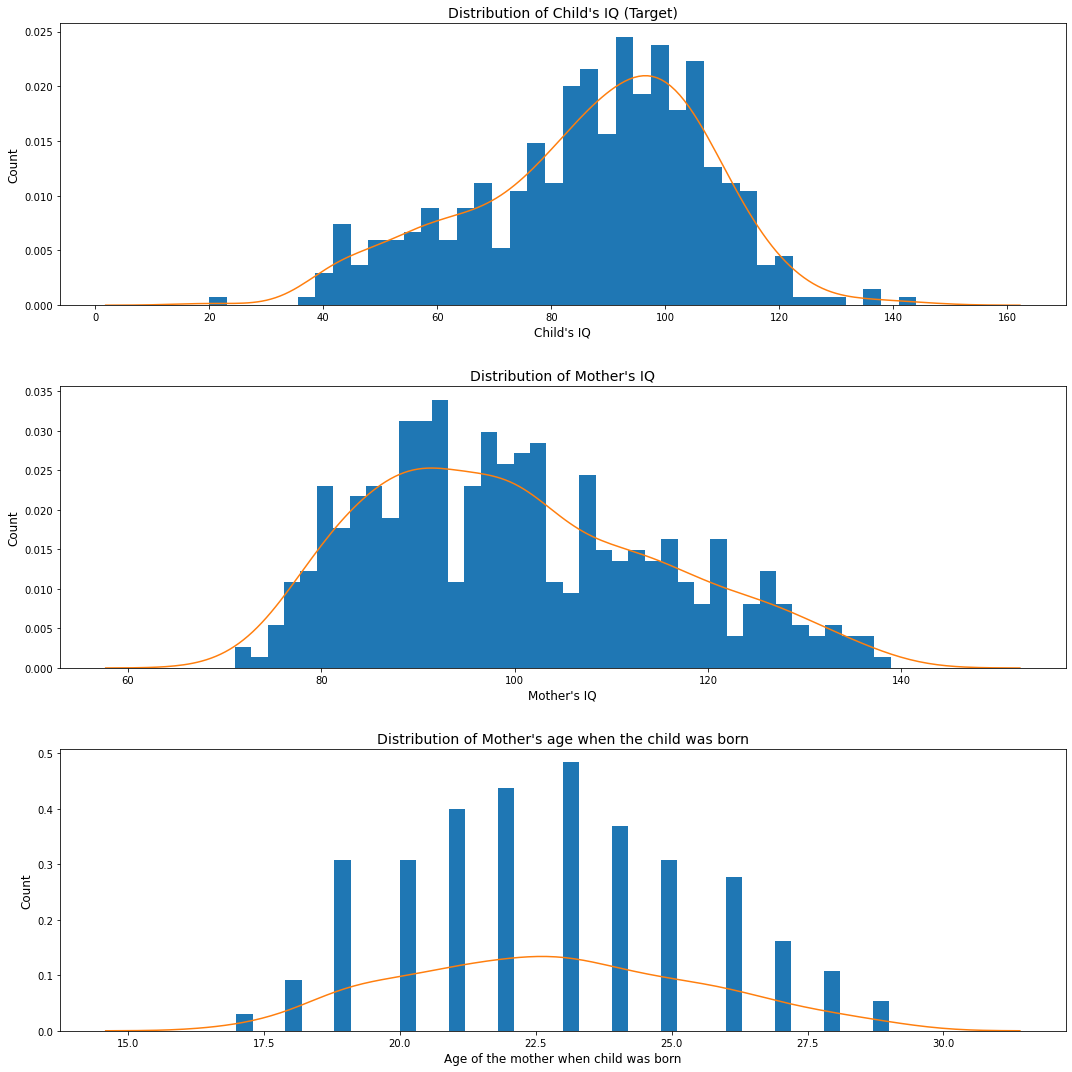

In [746]:
fig = plt.figure(figsize = (15,15))

ax1 = plt.subplot2grid((3,1),(0,0),rowspan =1,colspan = 1)
ax1.hist(data['IQ_of_the_child'], bins=40, density = True)
sns.kdeplot(data['IQ_of_the_child'])
ax1.set_title('Distribution of Child\'s IQ (Target)', fontsize=14)
ax1.set_xlabel('Child\'s IQ',fontsize = 12)
ax1.set_ylabel('Count',fontsize = 12)


ax1 = plt.subplot2grid((3,1),(1,0),rowspan =1,colspan = 1)
ax1.hist(data['IQ_of_the_mother'], bins=40, density = True)
sns.kdeplot(data['IQ_of_the_mother'])
ax1.set_title('Distribution of Mother\'s IQ', fontsize=14)
ax1.set_xlabel('Mother\'s IQ',fontsize = 12)
ax1.set_ylabel('Count',fontsize = 12)



ax1 = plt.subplot2grid((3,1),(2,0),rowspan =1,colspan = 1)
ax1.hist(data['mother_age'], bins=40, density = True)
sns.kdeplot(data['mother_age'])
ax1.set_title('Distribution of Mother\'s age when the child was born', fontsize=14)
ax1.set_xlabel('Age of the mother when child was born',fontsize = 12)
ax1.set_ylabel('Count',fontsize = 12)


plt.tight_layout(h_pad = 3,w_pad = 3)
plt.show()

In [747]:
data['mother_age'].unique()

array([27, 25, 18, 20, 23, 24, 19, 26, 17, 21, 22, 28, 29])

In [748]:
data['mother_age'].value_counts().sort_index()

17     4
18    12
19    40
20    40
21    52
22    57
23    63
24    48
25    40
26    36
27    21
28    14
29     7
Name: mother_age, dtype: int64

**Observations**
1. Mother's IQ & child's IQ both have continuous value and doesn't have a gap.
2. Mother's Age has discrete valaues. There are many discrete values so it makes sense to binn them together as get less number of categories.

In [749]:
def mother_age_binning(data):
    if data['mother_age'] >= 17 and data['mother_age'] < 20:
        return '17-19'
    elif data['mother_age'] >= 20 and data['mother_age'] < 23:
        return '20-22'
    elif data['mother_age'] >= 23 and data['mother_age'] < 26:
        return '23-25'
    else:
        return '25+'

In [750]:
data['mother_age_binned'] = data.apply(mother_age_binning, axis=1)

In [751]:
data['mother_age_binned'].value_counts().sort_index()

17-19     56
20-22    149
23-25    151
25+       78
Name: mother_age_binned, dtype: int64

### Variables w.r.t target variable

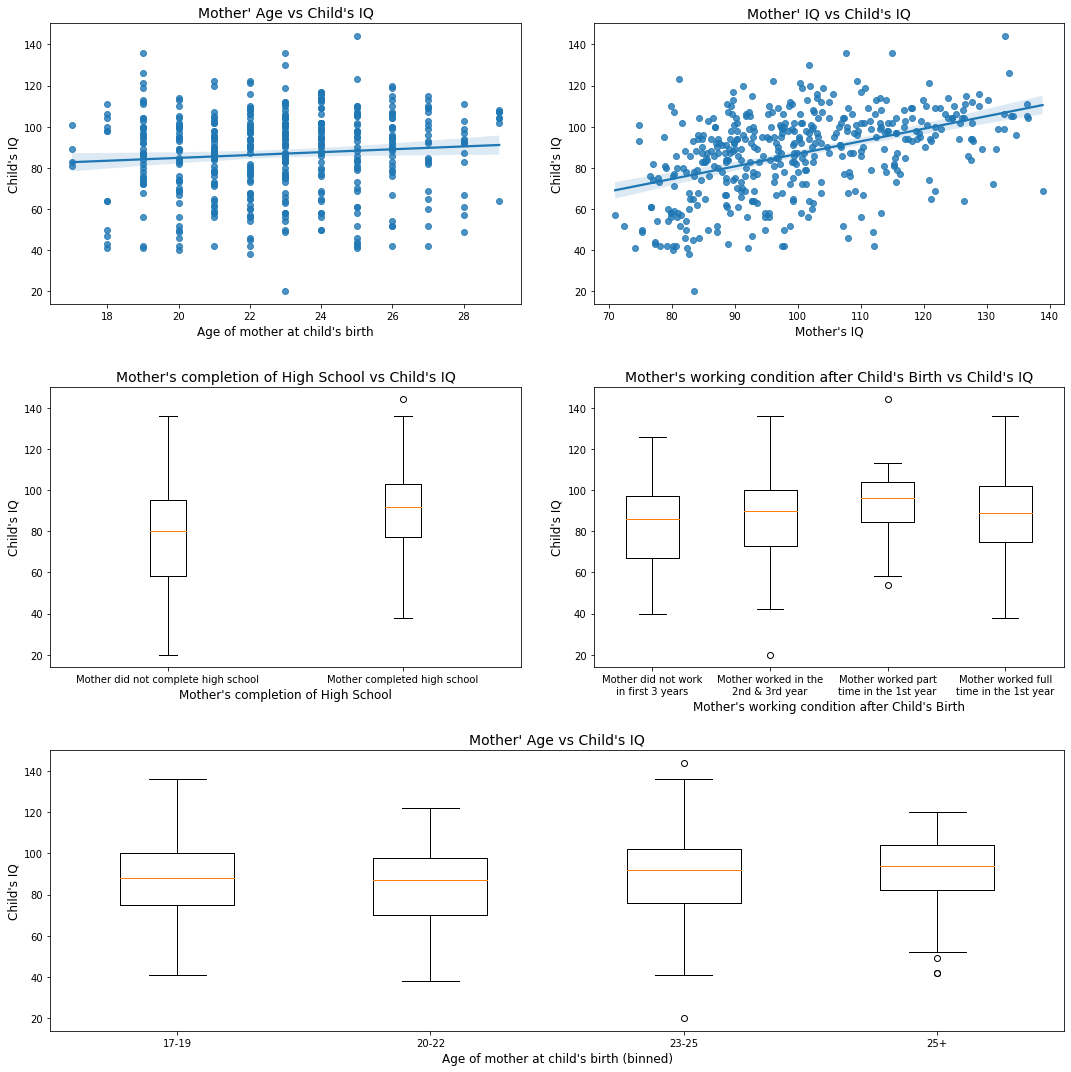

In [752]:
plt.figure(figsize = (15,15))
ax1 = plt.subplot2grid((3,2),(0,0),rowspan=1,colspan=1)
sns.regplot(data.mother_age, data.IQ_of_the_child, ax=ax1)
ax1.set_title('Mother\' Age vs Child\'s IQ',fontsize = 14)
ax1.set_xlabel('Age of mother at child\'s birth',fontsize = 12)
ax1.set_ylabel('Child\'s IQ',fontsize = 12)

ax1 = plt.subplot2grid((3,2),(0,1),rowspan=1,colspan=1)
sns.regplot(data.IQ_of_the_mother, data.IQ_of_the_child, ax=ax1)
ax1.set_title('Mother\' IQ vs Child\'s IQ',fontsize = 14)
ax1.set_xlabel('Mother\'s IQ',fontsize = 12)
ax1.set_ylabel('Child\'s IQ',fontsize = 12)


ax1 = plt.subplot2grid((3,2),(1,0),rowspan=1,colspan=1)
ax1.boxplot([data.loc[data['mother_high_school_flag'] == '0','IQ_of_the_child'],data.loc[data['mother_high_school_flag'] == '1','IQ_of_the_child']],labels = ['Mother did not complete high school','Mother completed high school'])
ax1.set_title('Mother\'s completion of High School vs Child\'s IQ',fontsize = 14)
ax1.set_xlabel('Mother\'s completion of High School',fontsize = 12)
ax1.set_ylabel('Child\'s IQ',fontsize = 12)

ax1 = plt.subplot2grid((3,2),(1,1),rowspan=1,colspan=1)
ax1.boxplot([data.loc[data['working_condition_of_mother'] == '1','IQ_of_the_child'],data.loc[data['working_condition_of_mother'] == '2','IQ_of_the_child'], data.loc[data['working_condition_of_mother'] == '3','IQ_of_the_child'], data.loc[data['working_condition_of_mother'] == '4','IQ_of_the_child']],labels = [ '\n'.join(wrap(l, 20)) for l in ['Mother did not work in first 3 years','Mother worked in the 2nd & 3rd year','Mother worked part time in the 1st year','Mother worked full time in the 1st year']])
ax1.set_title('Mother\'s working condition after Child\'s Birth vs Child\'s IQ',fontsize = 14)
ax1.set_xlabel('Mother\'s working condition after Child\'s Birth',fontsize = 12)
ax1.set_ylabel('Child\'s IQ',fontsize = 12)

ax1 = plt.subplot2grid((3,2),(2,0),rowspan=1,colspan=2)
ax1.boxplot([data.loc[data['mother_age_binned'] == '17-19','IQ_of_the_child'],data.loc[data['mother_age_binned'] == '20-22','IQ_of_the_child'],data.loc[data['mother_age_binned'] == '23-25','IQ_of_the_child'],data.loc[data['mother_age_binned'] == '25+','IQ_of_the_child']],labels = ['17-19','20-22','23-25','25+'])
ax1.set_title('Mother\' Age vs Child\'s IQ',fontsize = 14)
ax1.set_xlabel('Age of mother at child\'s birth (binned)',fontsize = 12)
ax1.set_ylabel('Child\'s IQ',fontsize = 12)

plt.tight_layout(h_pad = 2,w_pad = 3)
plt.show()

**Observations:**
1. Age of Mother doesn't seem to have a lot of impact on child's IQ. As the line of best fit is almost flat.
2. There seems to be a positive correlation between Mother's IQ and Child's IQ.
3. Mother who has completed high school seems to have child with higher IQ. As the boxplot for mother's that have completed high school is clearly higher as compared to Mother's who have not completed high school
4. Mother who was working part-time in the first year seems to have child with higher IQ. 

## Performing statistical tests to understand if the features are statistically significant in predicting for Child's IQ

1. <u> mother_high_school_flag </u>

For mother_high_school_flag as there are two categories, we can perform two sample t-test to verify statistically if it is significant. But, to do so we need to ensure that the two subsets i.e. mother_high_school_flag=1 & mother_high_school_flag=0 are normally distributed as it is one of the assumption of t-test.

In [765]:
shapiro(data.loc[data['mother_high_school_flag']=='1','IQ_of_the_child'])

ShapiroResult(statistic=0.9780992865562439, pvalue=4.6810542698949575e-05)

In [766]:
shapiro(data.loc[data['mother_high_school_flag']=='0','IQ_of_the_child'])

ShapiroResult(statistic=0.9641686081886292, pvalue=0.011815228499472141)

As the two subsets of data have pvalue < 0.05, we reject the null hypothesis and we can statistically say that both the distributions are not normally distributed. Now, as the subsets are not normally distributed, it means we can't perform parametric two sample t-test but would have to go for non-parametric Mann Whitney U test.

In [770]:
mannwhitneyu(data.loc[data['mother_high_school_flag']=='1','IQ_of_the_child'],data.loc[data['mother_high_school_flag']=='0','IQ_of_the_child'])


MannwhitneyuResult(statistic=20682.5, pvalue=6.748319364137073e-06)

**<i> As p-value <<< 0.5, high school completion is a <u> very significant </u> feature in predicting Child\'s IQ.  </i>**

2. <u> mother_age </u>

As mother's age has a lot of discrete values, each discrete value would have very few data points which would make it difficult to do any statistical test. To verify if mother's age is significant, statistical test is performed on the binned mother's age. As there are 4 categories within mother_age_binned we need to perform ANOVA test. But as the ANOVA test require that the subset should follow a normal distribution, we need to first test for normality.

In [772]:
shapiro(data.loc[data['mother_age_binned']=='17-19','IQ_of_the_child'])

ShapiroResult(statistic=0.9694849848747253, pvalue=0.16648827493190765)

In [773]:
shapiro(data.loc[data['mother_age_binned']=='20-22','IQ_of_the_child'])

ShapiroResult(statistic=0.9771718382835388, pvalue=0.013871666975319386)

In [775]:
shapiro(data.loc[data['mother_age_binned']=='23-25','IQ_of_the_child'])

ShapiroResult(statistic=0.9736491441726685, pvalue=0.0053278300911188126)

In [774]:
shapiro(data.loc[data['mother_age_binned']=='25+','IQ_of_the_child'])

ShapiroResult(statistic=0.9227983355522156, pvalue=0.00015720301598776132)

Apart from age band of '17-19' all the age bands have p-value < 0.05, it means the null hypothesis will be rejected and we can statistcally say that these subsets are not normally distributed. As they are not normally distributed, we need to perform non-parametric test i.e. Kruskal Walis test.

In [778]:
kruskal(data.loc[data['mother_age_binned']=='17-19','IQ_of_the_child'], data.loc[data['mother_age_binned']=='20-22','IQ_of_the_child'], data.loc[data['mother_age_binned']=='23-25','IQ_of_the_child'],data.loc[data['mother_age_binned']=='25+','IQ_of_the_child'])


KruskalResult(statistic=8.531929703475095, pvalue=0.03620708883279042)

**<i> As p-value < 0.5, high school completion is <u> little significant </u> feature in predicting Child\'s IQ.  </i>**

3. <u> working_condition_of_mother </u>

As there are 4 categories within working_condition_of_mother we need to perform ANOVA test. But as the ANOVA test require that the subset should follow a normal distribution, we need to first test for normality.

In [784]:
shapiro(data.loc[data['working_condition_of_mother']=='1','IQ_of_the_child'])

ShapiroResult(statistic=0.9661527872085571, pvalue=0.037982095032930374)

In [785]:
shapiro(data.loc[data['working_condition_of_mother']=='2','IQ_of_the_child'])

ShapiroResult(statistic=0.9709827899932861, pvalue=0.031543973833322525)

In [786]:
shapiro(data.loc[data['working_condition_of_mother']=='3','IQ_of_the_child'])

ShapiroResult(statistic=0.9443325400352478, pvalue=0.011948855593800545)

In [787]:
shapiro(data.loc[data['working_condition_of_mother']=='4','IQ_of_the_child'])

ShapiroResult(statistic=0.9719804525375366, pvalue=0.0004119227232877165)

As all working condition subsets have p-value < 0.05, it means the null hypothesis will be rejected and we can statistcally say that these subsets are not normally distributed. As they are not normally distributed, we need to perform non-parametric test i.e. Kruskal Walis test.

In [788]:
kruskal(data.loc[data['working_condition_of_mother']=='1','IQ_of_the_child'],data.loc[data['working_condition_of_mother']=='2','IQ_of_the_child'],data.loc[data['working_condition_of_mother']=='3','IQ_of_the_child'],data.loc[data['working_condition_of_mother']=='4','IQ_of_the_child'])


KruskalResult(statistic=10.587537543302048, pvalue=0.014178686908068519)

**<i> As p-value << 0.5, high school completion is a <u> significant </u> feature in predicting Child\'s IQ.  </i>**

4. <u> IQ_of_the_mother </u>

As IQ_of_the_mother is a continuous feature, we can perform pearson correlation to verify that IQ_of_the_mother & IQ_of_the_child (target) are correlated.

<AxesSubplot:xlabel='variable', ylabel='variable'>

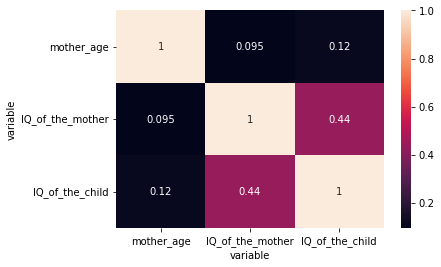

In [878]:
corr = data.corr()
sns.heatmap(corr, annot= True)

In [791]:
stats.pearsonr(data['IQ_of_the_mother'],data['IQ_of_the_child'])

(0.44827584226517375, 7.661949625348745e-23)

**<i> Mother's age & Mother's IQ does not have a high correlation. Child's IQ & Mother's IQ does seem to have a correlation, this corroborates our findings from the scatter plot above.</i>**

**Observations:**

1. Through the scatterplot Age of Mother doesn't seem to have a lot of impact on child's IQ. As the line of best fit is almost flat but through the statistical test it seems that it is a litlle significant (As p = 0.03)
2. Through the scatterplot there seems to be a positive correlation between Mother's IQ and Child's IQ and through the statistical test also, it is apparent that the Mother's IQ is very significant (As p = 7.6e-23)
3. Mother who has completed high school seems to have child with higher IQ. This is corroborated by both the boxplot and the statistical test (As p = 6.7e-06)
4. From the boxplot it can be noticed that mother who was working part-time in the first year seems to have child with higher IQ. Through the statistical tests, it becomes clear that this feature is significant (As p = 0.01)


## <font color='blue'><u> Outlier Detection </u></font>

To detect Outliers, univariate Outlier detection technique using IQR (Interquartile range) can be used. IQR measures the spread of the middle half of your data. It is the range for the middle 50% of your sample i.e. the difference between the 75th and 25th percentiles of the data. Now anything above 75th percentile + 1.5\*IQR & anything below 25th percentile - 1.5\*IQR is considered an outlier.

In [852]:
def Outlier_removal(data, column, condition, target):
    random_data = np.random.standard_normal(100000)
    if (column != '')&(condition != ''):
        q3, q1 = np.percentile(data.loc[data[column]==condition,target], [75, 25])
    else:
        q3, q1 = np.percentile(data.loc[:,target], [75, 25])
    print("Datapoints before outlier removal: " + str(len(data)))
    IQR = q3 - q1
    
    upper_bound = q3 + 1.5 * IQR
    lower_bound = q1 - 1.5 * IQR
    print("Upper bound: " + str(upper_bound))
    print("Lower bound: " + str(lower_bound))
    
    if (column != '')&(condition != ''):
        data1 = data.loc[(data[column]==condition)&((data[target] > upper_bound)|(data[target] < lower_bound))].index
    else:
        data1 = data.loc[((data[target] > upper_bound)|(data[target] < lower_bound))].index
    data = data.drop(data1)
    print("Datapoints after outlier removal: " + str(len(data)))
    return data

In [859]:
data = Outlier_removal(data,'mother_high_school_flag' , '1', 'IQ_of_the_child')

Datapoints before outlier removal: 434
Upper bound: 142.0
Lower bound: 38.0
Datapoints after outlier removal: 433


In [860]:
data = Outlier_removal(data,'working_condition_of_mother' , '2', 'IQ_of_the_child')

Datapoints before outlier removal: 433
Upper bound: 140.5
Lower bound: 32.5
Datapoints after outlier removal: 432


In [861]:
data = Outlier_removal(data,'working_condition_of_mother' , '3', 'IQ_of_the_child')

Datapoints before outlier removal: 432
Upper bound: 134.0
Lower bound: 54.0
Datapoints after outlier removal: 432


In [862]:
data = Outlier_removal(data,'mother_age_binned' , '25+', 'IQ_of_the_child')

Datapoints before outlier removal: 432
Upper bound: 136.625
Lower bound: 49.625
Datapoints after outlier removal: 429


In [863]:
data = Outlier_removal(data,'mother_age_binned' , '23-25', 'IQ_of_the_child')

Datapoints before outlier removal: 429
Upper bound: 141.0
Lower bound: 37.0
Datapoints after outlier removal: 429


In [864]:
data = Outlier_removal(data,'' , '', 'IQ_of_the_mother')

Datapoints before outlier removal: 429
Upper bound: 142.20554361761506
Lower bound: 56.58224367930823
Datapoints after outlier removal: 429


**<i>After removing all the outliers, the number of datapoints have become 429. As the original dataset had 434 data points this means that only 5 datapoints have been removed.<i>**

## <font color='blue'><u> Analysing correlation between independent features </u></font>

In [615]:
data.columns

Index(['mother_age', 'mother_high_school_flag', 'IQ_of_the_mother',
       'IQ_of_the_child', 'working_condition_of_mother'],
      dtype='object', name='variable')

There are 4 independent variables: mother_high_school_flag (categorical), IQ_of_the_mother (numerical), working_condition_of_mother (categorical), mother_age_binned (categorical). 

For getting correlation between:
1. categorical - categorical: Chisquare test can be used. This gives us a p-value & a value less than 0.05 means that the two variables are correlated to each other. To know the strength of the relationship,an essect size measure like Cramer's V need to be used. 

<table align="left">
<tr><td>Cramer's V</td><td>Interpretation</td></tr>
<tr><td> >0.25</td><td>Very Strong</td></tr>
<tr><td> >0.15</td><td>Strong</td></tr>
<tr><td> >0.10</td><td>Moderate</td></tr>
<tr><td> >0.05</td><td>Weak</td></tr>
<tr><td> >0</td><td>Very Weak</td></tr>
</table>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

2. categorical - numerical: ANOVA can be used provided each subgroup follows normal distribution. In case that assumption is violated, non-parametric test like Kruskal Wallis can be used.

1. <u> mother_age_binned & mother_high_school_flag: Chisquare Test </u>

In [869]:
crosstab = pd.crosstab(data["mother_age_binned"], data["mother_high_school_flag"])
stats.chi2_contingency(crosstab)

(22.91485528187637,
 4.206731027722609e-05,
 3,
 array([[ 11.74825175,  44.25174825],
        [ 31.25874126, 117.74125874],
        [ 31.25874126, 117.74125874],
        [ 15.73426573,  59.26573427]]))

In [870]:
import researchpy as rp
crosstab, test_results, expected = rp.crosstab(data["mother_high_school_flag"], data["mother_age_binned"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
test_results

,Chi-square test,results
0,Pearson Chi-square ( 3.0) =,22.9149
1,p-value =,0.0000
2,Cramer's V =,0.2311


**<i> Mother's age at child birth \& Mother\'s completion of high school are dependent \& there is a strong relationship between the two categorical variables. The p-value is < 0.05 & Cramer\'s V value is .23. </i>**

2. <u> mother_age_binned & working_condition_of_mother: Chisquare Test </u>

In [871]:
crosstab = pd.crosstab(data["mother_age_binned"], data["working_condition_of_mother"])
stats.chi2_contingency(crosstab)

(16.288167567614764,
 0.061102359463556216,
 9,
 array([[ 9.92074592, 12.27039627,  7.17948718, 26.62937063],
        [26.3962704 , 32.64801865, 19.1025641 , 70.85314685],
        [26.3962704 , 32.64801865, 19.1025641 , 70.85314685],
        [13.28671329, 16.43356643,  9.61538462, 35.66433566]]))

**<i> Mother's age at child birth \& Mother\'s workingcondition after child birth are independent \& there is statistically no relationship between the two categorical variables. The p-value is > 0.05. </i>**

3. <u> mother_high_school_flag & working_condition_of_mother: Chisquare Test </u>

In [872]:
crosstab = pd.crosstab(data["working_condition_of_mother"], data["mother_high_school_flag"])
stats.chi2_contingency(crosstab)

(30.192296966003862,
 1.2573135816926335e-06,
 3,
 array([[ 15.94405594,  60.05594406],
        [ 19.72027972,  74.27972028],
        [ 11.53846154,  43.46153846],
        [ 42.7972028 , 161.2027972 ]]))

In [873]:
import researchpy as rp
crosstab, test_results, expected = rp.crosstab(data["mother_high_school_flag"], data["working_condition_of_mother"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
test_results

,Chi-square test,results
0,Pearson Chi-square ( 3.0) =,30.1923
1,p-value =,0.0000
2,Cramer's V =,0.2653


**<i> Mother's completion of high school & Mother's working condition after child birth does have a dependency on each other i.e. there is a relationship between the two categorical variables. The p-value is < 0.05 & Cramer's V value is .26.</i>**

4. <u> mother_age_binned & IQ_of_the_mother: ANOVA / Kruskal Wallis </u>

Testing for Normality as this is an assumption taken by the ANOVA test

In [795]:
shapiro(data.loc[data['mother_age_binned']=='17-19','IQ_of_the_mother'])

ShapiroResult(statistic=0.9328998327255249, pvalue=0.003909562714397907)

In [796]:
shapiro(data.loc[data['mother_age_binned']=='20-22','IQ_of_the_mother'])

ShapiroResult(statistic=0.94659024477005, pvalue=1.8358970919507556e-05)

In [797]:
shapiro(data.loc[data['mother_age_binned']=='23-25','IQ_of_the_mother'])

ShapiroResult(statistic=0.9609742760658264, pvalue=0.00028613884933292866)

In [798]:
shapiro(data.loc[data['mother_age_binned']=='25+','IQ_of_the_mother'])

ShapiroResult(statistic=0.9567221999168396, pvalue=0.009725559502840042)

As the p-value for all the subgroup is < 0.05 that means they are not normally distributed. As they are not normally distributed, non-parametric statistical test (Kruskal Wallis) has to be used.

In [799]:
kruskal(data.loc[data['mother_age_binned']=='17-19','IQ_of_the_mother'], data.loc[data['mother_age_binned']=='20-22','IQ_of_the_mother'], data.loc[data['mother_age_binned']=='23-25','IQ_of_the_mother'],data.loc[data['mother_age_binned']=='25+','IQ_of_the_mother'])


KruskalResult(statistic=6.414333529664097, pvalue=0.09310289744607662)

**<i> As the p-value > 0.05 that means we fail to reject the null hypothesis and mother_age_binned & IQ_of_the_mother are not dependent & there is no relationship between the variables. </i>**

5. <u> working_condition_of_mother & IQ_of_the_mother: ANOVA / Kruskal Wallis </u>

Testing for Normality as this is an assumption taken by the ANOVA test

In [800]:
shapiro(data.loc[data['working_condition_of_mother']=='1','IQ_of_the_mother'])

ShapiroResult(statistic=0.9358122944831848, pvalue=0.000752303923945874)

In [801]:
shapiro(data.loc[data['working_condition_of_mother']=='2','IQ_of_the_mother'])

ShapiroResult(statistic=0.9805067777633667, pvalue=0.1640300452709198)

In [802]:
shapiro(data.loc[data['working_condition_of_mother']=='3','IQ_of_the_mother'])

ShapiroResult(statistic=0.9778384566307068, pvalue=0.38918420672416687)

In [803]:
shapiro(data.loc[data['working_condition_of_mother']=='4','IQ_of_the_mother'])

ShapiroResult(statistic=0.9600163102149963, pvalue=1.5650417481083423e-05)

As the p-value for all the subgroup is < 0.05 that means they are not normally distributed. As they are not normally distributed, non-parametric statistical test (Kruskal Wallis) has to be used.

In [804]:
kruskal(data.loc[data['working_condition_of_mother']=='1','IQ_of_the_mother'],data.loc[data['working_condition_of_mother']=='2','IQ_of_the_mother'],data.loc[data['working_condition_of_mother']=='3','IQ_of_the_mother'],data.loc[data['working_condition_of_mother']=='4','IQ_of_the_mother'])


KruskalResult(statistic=13.96541424984323, pvalue=0.002952609878294879)

**<i> As the p-value < 0.05 that means we reject the null hypothesis and working_condition_of_mother & IQ_of_the_mother are dependent & there is a relationship between the variables. </i>**

6. <u> mother_high_school_flag & IQ_of_the_mother: 2 sample t-test / Mann Whitney U test </u>

Testing for Normality as this is an assumption taken by the 2 sample t-test test

In [805]:
shapiro(data.loc[data['mother_high_school_flag']=='1','IQ_of_the_mother'])

ShapiroResult(statistic=0.972172737121582, pvalue=3.871217359119328e-06)

In [806]:
shapiro(data.loc[data['mother_high_school_flag']=='0','IQ_of_the_mother'])

ShapiroResult(statistic=0.928447961807251, pvalue=7.495938189094886e-05)

As the p-value for all the subgroup is < 0.05 that means they are not normally distributed. As they are not normally distributed, non-parametric statistical test (Mann Whitney U) has to be used.

In [807]:
mannwhitneyu(data.loc[data['mother_high_school_flag']=='1','IQ_of_the_mother'],data.loc[data['mother_high_school_flag']=='0','IQ_of_the_mother'])


MannwhitneyuResult(statistic=22462.5, pvalue=7.23912927065149e-10)

**<i>As the p-value < 0.05 that means we reject the null hypothesis and mother_high_school_flag & IQ_of_the_mother are dependent & there is a relationship between the variables.</i>**

**Observations:**
1. There is a relationship/dependency between all the independent variables except between mother_age_binned & working_condition_of_mother, mother_age_binned & IQ_of_the_mother
2. As there are lot of dependencies, it doesn't make sense to drop the feature when building a mutiple linear regression as we won't have any features left if we only consider this. So, to build mutiple linear regression it makes more sense to look at Adj. R-squared for differnt models and choose the one, which gives the highest Adj. R-squared.

## <font color='blue'><u> Assumptions of Linear Regression </u></font>

1. There must be a linear relationship between the dependent and independent variables - From the plots we can notice that it is true.
2. Sample observations are independent - Yes as each datapoint has different value for an observation so thsey are independent of each other.
3. No outliers are present in the data - Outliers have alkready been treated.
4. No multicollinearity - When the independent variables in my model are highly linearly related then such a situation is called multicollinearity. As observed above we see collinearity between every independent variable (except between mother_age_binned & working_condition_of_mother, mother_age_binned & IQ_of_the_mother). As there are lot of dependencies, it doesn't make sense to drop the feature when building a mutiple linear regression as we won't have any features left if we only consider this. So, to build mutiple linear regression it makes more sense to look at Adj. R-squared for differnt models and choose the one, which gives the highest Adj. R-squared.
5. Error terms are identically and independently distributed. (Independence means absence of autocorrelation) - Will be checked after the model has been built.
6. Error terms have constant variance i.e. there is no heteroscedasticity - Will be checked after the model has been built.
7. Error terms are normally distributed with mean 0 - Will be checked after the model has been built.


## <font color='blue'><u> Linear Regression </u></font>

**Preparing data for Modelling**

<u> Encoding Categorical features </u>

In [995]:
data.columns

Index(['mother_age', 'mother_high_school_flag', 'IQ_of_the_mother',
       'IQ_of_the_child', 'working_condition_of_mother', 'mother_age_binned'],
      dtype='object', name='variable')

In [996]:
data1 = data.drop(['mother_age'], axis = 1)

In [997]:
data1.columns

Index(['mother_high_school_flag', 'IQ_of_the_mother', 'IQ_of_the_child',
       'working_condition_of_mother', 'mother_age_binned'],
      dtype='object', name='variable')

<b><div class="alert alert-block alert-success">NOTE: One Hot encoding was also tried but the results were similar to Target Mean Encoding. The latter was chosen, as it results in lesser number of features. </div></b>

In [998]:
tenc=ce.TargetEncoder() 
data_encode1=tenc.fit_transform(data1['mother_age_binned'],data1['IQ_of_the_child'])
data_encode1 = data_encode1.join(data1.drop('mother_age_binned',axis = 1))
data_encode1

,mother_age_binned,mother_high_school_flag,IQ_of_the_mother,IQ_of_the_child,working_condition_of_mother
0,91.880000,1,121.117529,65,4
1,88.268456,1,89.361882,98,4
2,91.880000,1,115.443165,85,4
3,88.268456,1,99.449639,83,3
4,91.880000,1,92.745710,115,4
...,...,...,...,...,...
429,83.590604,0,84.877412,94,4
430,88.268456,1,92.990392,76,4
431,88.268456,0,94.859708,50,2
432,83.590604,1,96.856624,88,2


In [999]:
tenc=ce.TargetEncoder() 
tenc1=tenc.fit_transform(data_encode1['mother_high_school_flag'],data_encode1['IQ_of_the_child'])
data_encode1 = tenc1.join(data_encode1.drop('mother_high_school_flag',axis = 1))
data_encode1

,mother_high_school_flag,mother_age_binned,IQ_of_the_mother,IQ_of_the_child,working_condition_of_mother
0,89.297935,91.880000,121.117529,65,4
1,89.297935,88.268456,89.361882,98,4
2,89.297935,91.880000,115.443165,85,4
3,89.297935,88.268456,99.449639,83,3
4,89.297935,91.880000,92.745710,115,4
...,...,...,...,...,...
429,78.900000,83.590604,84.877412,94,4
430,89.297935,88.268456,92.990392,76,4
431,78.900000,88.268456,94.859708,50,2
432,89.297935,83.590604,96.856624,88,2


In [1000]:
tenc=ce.TargetEncoder() 
tenc1=tenc.fit_transform(data_encode1['working_condition_of_mother'],data_encode1['IQ_of_the_child'])
data_encode1 = tenc1.join(data_encode1.drop('working_condition_of_mother',axis = 1))
data_encode1

,working_condition_of_mother,mother_high_school_flag,mother_age_binned,IQ_of_the_mother,IQ_of_the_child
0,87.431373,89.297935,91.880000,121.117529,65
1,87.431373,89.297935,88.268456,89.361882,98
2,87.431373,89.297935,91.880000,115.443165,85
3,92.581818,89.297935,88.268456,99.449639,83
4,87.431373,89.297935,91.880000,92.745710,115
...,...,...,...,...,...
429,87.431373,78.900000,83.590604,84.877412,94
430,87.431373,89.297935,88.268456,92.990392,76
431,87.021277,78.900000,88.268456,94.859708,50
432,87.021277,89.297935,83.590604,96.856624,88


<u> Splitting data in training & test set </u>

In [1001]:
from sklearn.model_selection import train_test_split
X = data_encode1.drop('IQ_of_the_child',axis=1) # Independent variable
y = data_encode1['IQ_of_the_child'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=23)

<u> Standardizing the data </u>

In [1002]:
scalar = StandardScaler()
X_train_scaled = pd.DataFrame(scalar.fit_transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(scalar.transform(X_test),columns=X_test.columns)

In [1018]:
y_train = y_train.reset_index().drop(['index'],axis=1)

In [1020]:
y_test = y_test.reset_index().drop(['index'],axis=1)

### Single Predictor Linear Models

In [1113]:
from sklearn.metrics import mean_squared_error

In [1114]:
model_results = pd.DataFrame()
for i in X_train.columns:
    X = X_train_scaled[[i]]
    X = sm.add_constant(X)
    X1 = X_test_scaled[[i]]
    X1 = sm.add_constant(X1)
    model = sm.OLS(y_train, X).fit()
    model_results = model_results.append({'Single_Predictor':i,'Adjusted_R_squared':model.rsquared_adj,'Training Mean Squared error':mean_squared_error(y_train, model.predict(X)),'Test Mean Squared error':mean_squared_error(y_test, model.predict(X1))},ignore_index=True)
model_results.sort_values(by='Adjusted_R_squared',ascending=False)

,Single_Predictor,Adjusted_R_squared,Training Mean Squared error,Test Mean Squared error
3,IQ_of_the_mother,0.201854,307.164215,350.199964
1,mother_high_school_flag,0.044960,367.544516,389.844449
0,working_condition_of_mother,0.018501,377.726997,399.612510
2,mother_age_binned,0.013980,379.467094,388.892563


**<i> As the Adjusted R-squared value of .20 is the highest for a single predictor linear model. This model should be chosen. Now, the assumprtion regarding the error term need to be checked for this model. </i>**

In [1116]:
X = X_train_scaled['IQ_of_the_mother']
X = sm.add_constant(X)
X1 = X_test_scaled[['IQ_of_the_mother']]
X1 = sm.add_constant(X1)
model = sm.OLS(y_train, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        IQ_of_the_child   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     87.49
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           1.16e-18
Time:                        19:23:26   Log-Likelihood:                -1468.9
No. Observations:                 343   AIC:                             2942.
Df Residuals:                     341   BIC:                             2950.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               87.5773      0.949     92.275      0.000      85.710      89.444
IQ_of_the_mother     8.8776      0.949      9.354      0.000       7.011      10.744
==============================================================================
Omnibus:                        5.300   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                5.238
Skew:                          -0.303   Prob(JB):                       0.0729
Kurtosis:                       3.017   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1117]:
print('Training Mean Squared error: ' + str(mean_squared_error(y_train, model.predict(X))) + '\n' + 'Test Mean Squared error: ' + str(mean_squared_error(y_test, model.predict(X1))))

Training Mean Squared error: 307.1642149861694
Test Mean Squared error: 350.1999636846405


<u> Checking for assumptions </u>

eval_env: 1


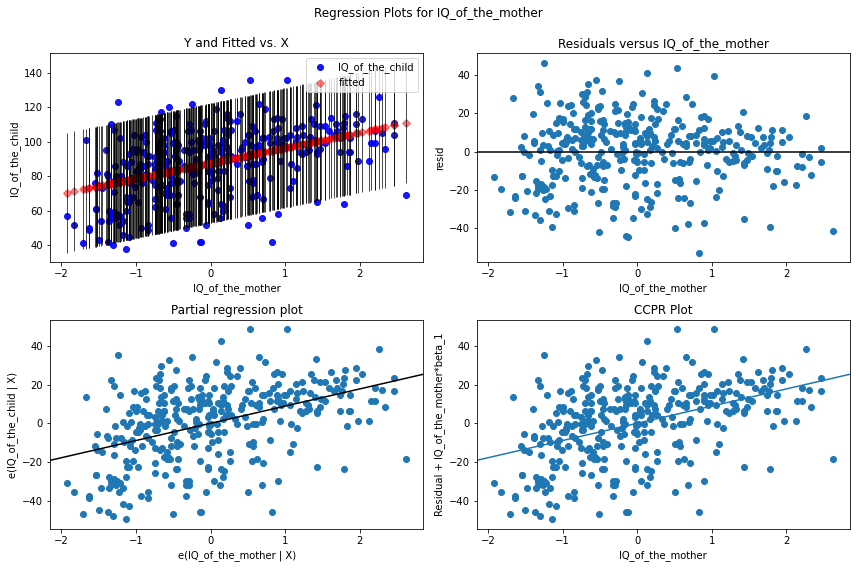

In [1034]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model,'IQ_of_the_mother',fig=fig)

**<i>We can see that the points are plotted randomly spread or scattered. points or residuals are scattered around the ‘0’ line, there is no pattern, and points are not based on one side so there’s no problem of heteroscedasticity.  with the predictor variable ‘IQ_of_the_mother’ there’s no heteroscedasticity.</i>**

In [1118]:
model.params

const               87.577259
IQ_of_the_mother     8.877589
dtype: float64

**<i>This means with a unit increase in IQ_of_the_mother (standardized) there is a increase of 8.87 times the IQ_of_the_child.</i>**

### Multiple Predictor Linear Models

In [1094]:
from itertools import combinations

In [1119]:
model_results = pd.DataFrame()
for i in range(2,len(X_train.columns)+1):
    for j in list(combinations(X_train.columns,i)):
        X = X_train_scaled[list(j)]
        X = sm.add_constant(X)
        X1 = X_test_scaled[list(j)]
        X1 = sm.add_constant(X1)
        model = sm.OLS(y_train, X).fit()
        model_results = model_results.append({'Multiple_Predictor':j,'Adjusted_R_squared':model.rsquared_adj,'AIC':model.aic,'BIC':model.bic,'Training Mean Squared error':mean_squared_error(y_train, model.predict(X)),'Test Mean Squared error':mean_squared_error(y_test, model.predict(X1))},ignore_index=True)
model_results.sort_values(by='Adjusted_R_squared',ascending=False)


,Multiple_Predictor,Adjusted_R_squared,AIC,BIC,Training Mean Squared error,Test Mean Squared error
10,"(working_condition_of_mother, mother_high_scho...",0.216691,2938.417184,2957.605836,298.802363,343.415592
7,"(working_condition_of_mother, mother_high_scho...",0.213888,2938.655498,2954.006420,300.758633,350.465074
9,"(mother_high_school_flag, mother_age_binned, I...",0.213488,2938.830025,2954.180947,300.911705,343.876522
8,"(working_condition_of_mother, mother_age_binne...",0.211202,2939.825429,2955.176351,301.786236,341.351604
4,"(mother_high_school_flag, IQ_of_the_mother)",0.211145,2938.860373,2950.373564,302.698199,350.871172
2,"(working_condition_of_mother, IQ_of_the_mother)",0.206642,2940.812841,2952.326033,304.426169,349.528232
5,"(mother_age_binned, IQ_of_the_mother)",0.206001,2941.089847,2952.603039,304.672123,341.841008
6,"(working_condition_of_mother, mother_high_scho...",0.063032,2998.869055,3014.219977,358.474593,376.907714
0,"(working_condition_of_mother, mother_high_scho...",0.054954,3000.823757,3012.336948,362.631632,387.730633
3,"(mother_high_school_flag, mother_age_binned)",0.052158,3001.837126,3013.350317,363.704585,378.862483


**<i> As the Adjusted R-squared value of first five models is approximately same .21 \& the Training Mean squared error (≈ 300) \& test Mean squared error (≈ 345) is also approximately  same. The model can be decided based on AIC \& BIC. The model which has only 2 predictors can be chosen: (mother_high_school_flag, IQ_of_the_mother) as it has the least AIC \& BIC. Also according to Occam's razor this should be chosen as this model has only 2 predictors. The other models have higher number of predictors but give approximately the same result as this model.</i>**
    
**<i>Occam's razor is a principle of theory construction or evaluation according to which, other things equal, explanations that posit fewer entities, or fewer kinds of entities, are to be preferred to explanations that posit more.</i>**

In [1120]:
X = X_train_scaled[['IQ_of_the_mother','mother_high_school_flag']]
X = sm.add_constant(X)
X1 = X_test_scaled[['IQ_of_the_mother','mother_high_school_flag']]
X1 = sm.add_constant(X1)
model = sm.OLS(y_train, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        IQ_of_the_child   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     46.77
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.14e-18
Time:                        00:43:45   Log-Likelihood:                -1466.4
No. Observations:                 343   AIC:                             2939.
Df Residuals:                     340   BIC:                             2950.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      87.5773      0.944     92.817      0.000      85.721      89.433
IQ_of_the_mother            8.3242      0.975      8.534      0.000       6.406      10.243
mother_high_school_flag     2.1845      0.975      2.240      0.026       0.266       4.103
==============================================================================
Omnibus:                        5.862   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                5.850
Skew:                          -0.320   Prob(JB):                       0.0537
Kurtosis:                       3.001   Cond. No.                         1.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1121]:
print('Training Mean Squared error: ' + str(mean_squared_error(y_train, model.predict(X))) + '\n' + 'Test Mean Squared error: ' + str(mean_squared_error(y_test, model.predict(X1))))


Training Mean Squared error: 302.6981988676369
Test Mean Squared error: 350.87117184545673


<u> Checking for assumptions </u>

eval_env: 1


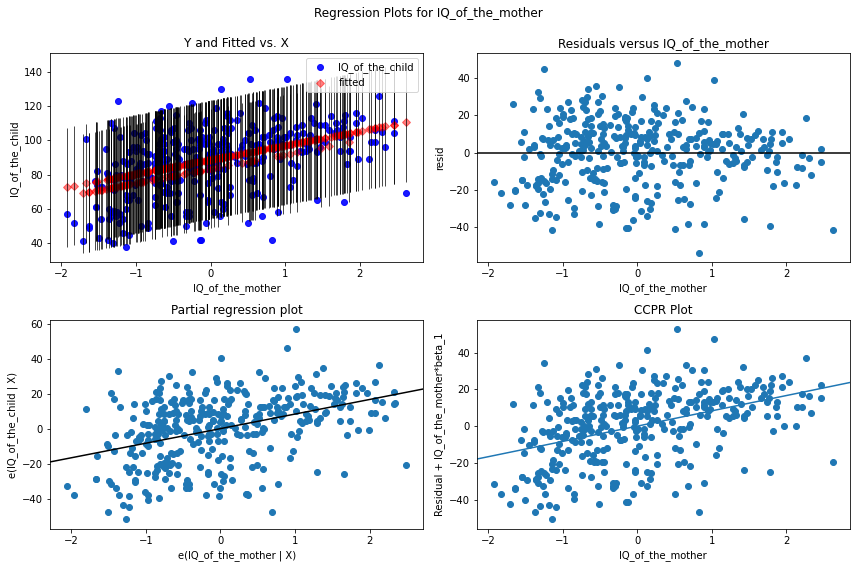

In [1039]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model,'IQ_of_the_mother',fig=fig)

eval_env: 1


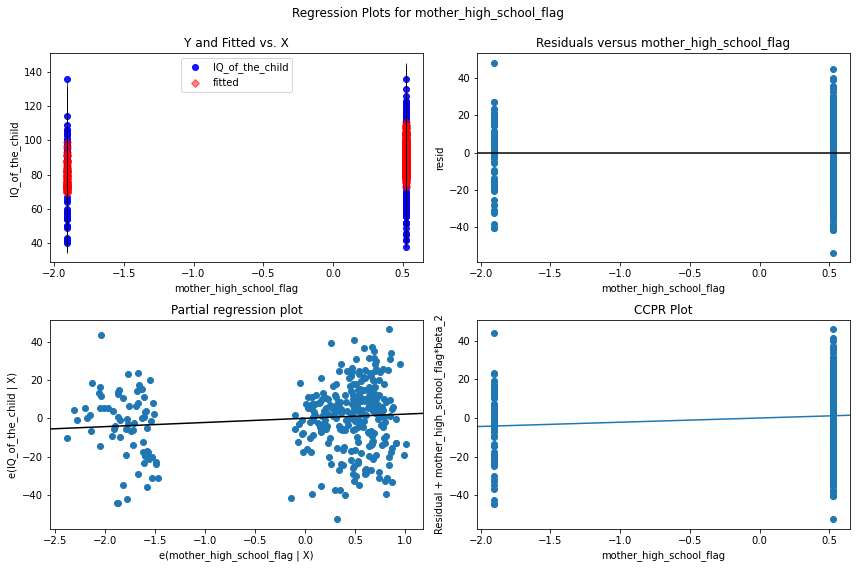

In [1040]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model,'mother_high_school_flag',fig=fig)

**<i>We can see that the points in both the plots are plotted randomly spread or scattered. Points or residuals are scattered around the ‘0’ line, there is no pattern, and points are not based on one side so there’s no problem of heteroscedasticity.  With both the predictor variables ‘IQ_of_the_mother’ & 'mother_high_school_flag' there’s no heteroscedasticity.</i>**

In [1122]:
model.params

const                      87.577259
IQ_of_the_mother            8.324218
mother_high_school_flag     2.184545
dtype: float64

**<i>This means that if the IQ_of_the_mother (standarized) is increased by 1 unit (provided mother_high_school_flag is unchanged) then there is 8.32 times increase in the IQ of the child. Also, if the mother_high_school_flag (standardized) is increased by 1 unit (provided IQ_of_the_mother is unchanged) then there is 2.18 times increase in the IQ of the child.</i>**

**<i>By seeing the absolue value of the coefficient, their feature imporatnce can also be concluded: IQ_of_the_mother is more important than mother_high_school_flag as the coefficent value is 8.32 \& 2.18 respectively. </i>**

### Mutliple Predictor Linear Model with Interaction

In [1123]:
poly = PolynomialFeatures(interaction_only=True)
X_tr = poly.fit_transform(X_train_scaled)

In [1124]:
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x1 x2',
 'x1 x3',
 'x2 x3']

In [1125]:
poly.get_feature_names(X_train_scaled.columns)

['1',
 'working_condition_of_mother',
 'mother_high_school_flag',
 'mother_age_binned',
 'IQ_of_the_mother',
 'working_condition_of_mother mother_high_school_flag',
 'working_condition_of_mother mother_age_binned',
 'working_condition_of_mother IQ_of_the_mother',
 'mother_high_school_flag mother_age_binned',
 'mother_high_school_flag IQ_of_the_mother',
 'mother_age_binned IQ_of_the_mother']

So, x0 = working_condition_of_mother, x1 = mother_high_school_flag, x2 = mother_age_binned, x3 = IQ_of_the_mother

In [1126]:
model = sm.OLS(y_train, X_tr).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        IQ_of_the_child   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     11.28
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.21e-16
Time:                        00:50:11   Log-Likelihood:                -1457.9
No. Observations:                 343   AIC:                             2938.
Df Residuals:                     332   BIC:                             2980.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.3472      0.993     88.944      0.000      86.393      90.301
x1             1.1320      0.994      1.139      0.255      -0.823       3.087
x2             1.0581      1.120      0.944      0.346      -1.146       3.262
x3             1.5149      0.963      1.572      0.117      -0.380       3.410
x4             8.3166      0.985      8.441      0.000       6.379      10.255
x5            -0.4272      0.961     -0.445      0.657      -2.317       1.463
x6             1.2590      0.982      1.283      0.201      -0.672       3.190
x7            -0.2341      0.945     -0.248      0.804      -2.092       1.624
x8             0.7290      1.115      0.654      0.514      -1.464       2.922
x9            -2.3268      1.138     -2.045      0.042      -4.565      -0.088
x10           -1.5276      0.966     -1.581      0.115      -3.429       0.374
==============================================================================
Omnibus:                        6.962   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                6.972
Skew:                          -0.349   Prob(JB):                       0.0306
Kurtosis:                       3.029   Cond. No.                         2.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**<i>This model has all the features and all the interactions, it has adjusted R-squared of .231 & AIC of 2938. & BIC of 2980.</i>**

<u>Trying another model with lesser number of features.</u>

In [1127]:
poly = PolynomialFeatures(interaction_only=True)
X_tr = poly.fit_transform(X_train_scaled[['IQ_of_the_mother','mother_high_school_flag']])

In [1128]:
X_te = poly.transform(X_test_scaled[['IQ_of_the_mother','mother_high_school_flag']])

In [1129]:
poly.get_feature_names()

['1', 'x0', 'x1', 'x0 x1']

In [1130]:
poly.get_feature_names(X_train_scaled.columns)

['1',
 'working_condition_of_mother',
 'mother_high_school_flag',
 'working_condition_of_mother mother_high_school_flag']

So, x1 - working_condition_of_mother, x2 - mother_high_school_flag, x3 - working_condition_of_mother mother_high_school_flag

In [1131]:
model = sm.OLS(y_train, X_tr).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        IQ_of_the_child   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     34.54
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.68e-19
Time:                        00:50:17   Log-Likelihood:                -1462.4
No. Observations:                 343   AIC:                             2933.
Df Residuals:                     339   BIC:                             2948.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.3341      0.971     90.982      0.000      86.424      90.244
x1             8.6319      0.971      8.887      0.000       6.721      10.542
x2             1.0606      1.043      1.017      0.310      -0.991       3.112
x3            -2.9876      1.049     -2.849      0.005      -5.051      -0.925
==============================================================================
Omnibus:                        6.904   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                6.948
Skew:                          -0.349   Prob(JB):                       0.0310
Kurtosis:                       3.005   Cond. No.                         1.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1132]:
print('Training Mean Squared error: ' + str(mean_squared_error(y_train, model.predict(X_tr))) + '\n' + 'Test Mean Squared error: ' + str(mean_squared_error(y_test, model.predict(X_te))))


Training Mean Squared error: 295.62246737273296
Test Mean Squared error: 340.0812778279867


**<i>This Model is beeter as it has lesser number of features and have almost the same Adj. R-squared (.227) as the last model (.231) & the AIC & BIC are actually better than the last model. The AIC is 2933. while it was 2938. for the last model. The BIC is 2948. while it was 2980. for the last model. So, this model should be chosen. (In case of AIC & BIC lesser is better while in case of Adjusted R-squared more is better).</i>**

<u> Checking for assumptions </u>

eval_env: 1


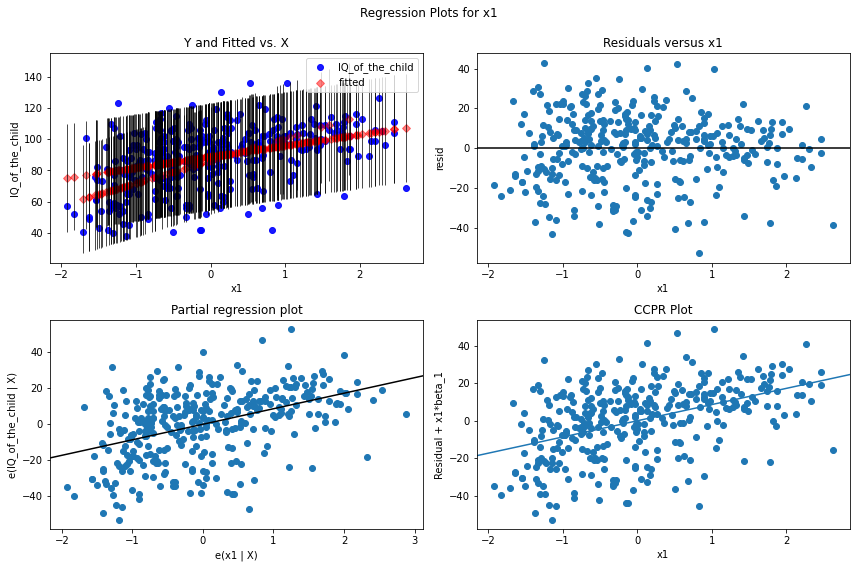

In [1078]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model,'x1',fig=fig)

eval_env: 1


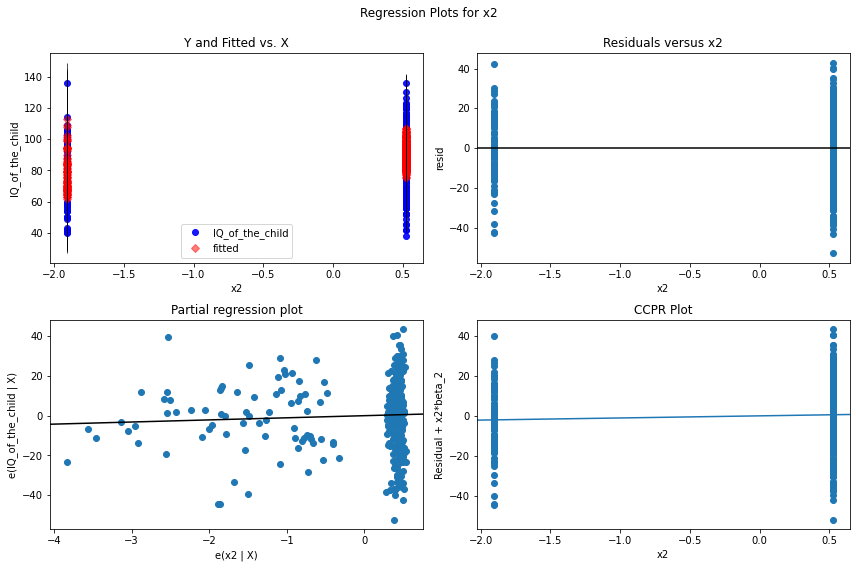

In [1079]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model,'x2',fig=fig)

eval_env: 1


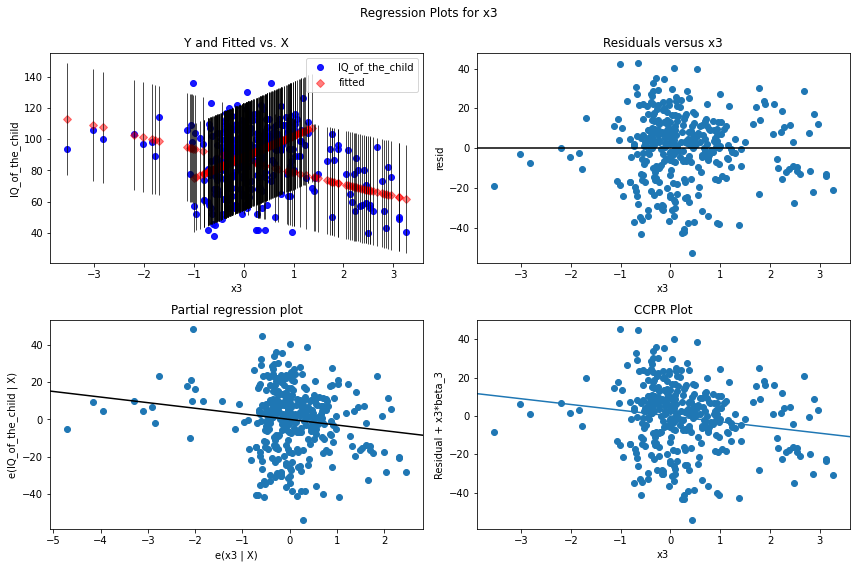

In [1080]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model,'x3',fig=fig)

**<i>We can see that the points in all the plots are plotted randomly spread or scattered. Points or residuals are scattered around the ‘0’ line, there is no pattern, and points are not based on one side so there’s no problem of heteroscedasticity.  With all the predictor variables ‘IQ_of_the_mother’,'mother_high_school_flag','IQ_of_the_mother mother_high_school_flag' there’s no heteroscedasticity.</i>**

In [1133]:
model.params

const    88.334059
x1        8.631863
x2        1.060634
x3       -2.987619
dtype: float64

**<i>This means that: </i>**

<i>**1. If the IQ_of_the_mother (standarized) is increased by 1 unit (provided the other predictors are unchanged) then there is 8.63 times increase in the IQ of the child.</i>**

<i>**2. If the mother_high_school_flag (standardized) is increased by 1 unit (provided the other predictors are unchanged) then there is 1.06 times increase in the IQ of the child.</i>**

<i>**3. If the mother_high_school_flag * mother_high_school_flag (standardized) is increased by 1 unit (provided the other predictors are unchanged) then there is 2.98 times decrease in the IQ of the child.</i>**

**<i>By seeing the absolue value of the coefficient, their feature imporatnce can also be concluded: IQ_of_the_mother is more important than the iteraction term i.e IQ_of_the_mother * mother_high_school_flag which is followed by mother_high_school_flag as the absolute value of coefficent is 8.63, 2.98 \& 1.06 respectively. </i>**

## <font color='blue'><u> Conclusion </u></font>

<table align="left">
<tr><td><b>Type of Model</b></td><td><b>Predictors</b></td><td><b>Adjusted R-squared</b></td><td><b>Training Mean Squared Error</b></td><td><b>Test Mean Squared Error</b></td></tr>
<tr><td> Single Predictor</td><td>IQ_of_the_mother</td><td>.202</td><td>307.164</td><td>350.199</td></tr>
<tr><td> Multiple Predictor</td><td>IQ_of_the_mother, mother_high_school_flag </td><td>.211</td><td>302.698</td><td>350.871</td></tr>
<tr><td> Multiple Predictor with Interaction</td><td>IQ_of_the_mother, mother_high_school_flag, IQ_of_the_mother mother_high_school_flag</td><td>.227</td><td>295.622</td><td>340.081</td></tr>
</table>

### <b>The Multiple Predictor with Interaction term is the best model. As, An interaction occurs when an independent variable has a different effect on the outcome depending on the values of another independent variable. This is the case here as IQ_of_the_mother, mother_high_school_flag have a clear relationship (based on statistical test). This model gives the highest Adjusted R-squared but the lowest AIC & BIC value among these models.</b>